In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# MAIN_PATH = '../input/'
df = pd.read_csv('bank_data.csv')
term_deposits = df.copy()
# Have a grasp of how our data looks.
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [2]:
from sklearn.model_selection import StratifiedShuffleSplit
# Here we split the data into training and test sets and implement a stratified shuffle split.
stratified = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_set, test_set in stratified.split(term_deposits, term_deposits["loan"]):
    stratified_train = term_deposits.loc[train_set]
    stratified_test = term_deposits.loc[test_set]
    
stratified_train["loan"].value_counts()/len(df)
stratified_test["loan"].value_counts()/len(df)

no     0.173894
yes    0.026160
Name: loan, dtype: float64

In [3]:
# Separate the labels and the features.
train_data = stratified_train # Make a copy of the stratified training set.
test_data = stratified_test
train_data.shape
test_data.shape
train_data['deposit'].value_counts()

no     4697
yes    4232
Name: deposit, dtype: int64

In [4]:
df.shape

(11162, 17)

In [5]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, no need to try to
# understand every line.
# Code reference Hands on Machine Learning with Scikit Learn and Tensorflow by Aurelien Geron.

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]
        #print(f"Label encoded: ", self.categories_)
        #print([le.inverse_transform() for le in self._label_encoders_])

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])
            print(f"Label encoded: ", np.unique(X_int[:,i]))
            print(f"Label actual: ", self._label_encoders_[i].inverse_transform(np.unique(X_int[:,i])))

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Making pipelines
numerical_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(["age", "balance", "day", "campaign", "pdays", "previous","duration"])),
    ("std_scaler", StandardScaler()),
])

categorical_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(["job", "education", "marital", "default", "housing", "loan", "contact", "month",
                                     "poutcome"])),
    ("cat_encoder", CategoricalEncoder(encoding='onehot-dense'))
])

from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("numerical_pipeline", numerical_pipeline),
        ("categorical_pipeline", categorical_pipeline),
    ])

In [8]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

Label encoded:  [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label actual:  ['admin.' 'blue-collar' 'entrepreneur' 'housemaid' 'management' 'retired'
 'self-employed' 'services' 'student' 'technician' 'unemployed' 'unknown']
Label encoded:  [0 1 2 3]
Label actual:  ['primary' 'secondary' 'tertiary' 'unknown']
Label encoded:  [0 1 2]
Label actual:  ['divorced' 'married' 'single']
Label encoded:  [0 1]
Label actual:  ['no' 'yes']
Label encoded:  [0 1]
Label actual:  ['no' 'yes']
Label encoded:  [0 1]
Label actual:  ['no' 'yes']
Label encoded:  [0 1 2]
Label actual:  ['cellular' 'telephone' 'unknown']
Label encoded:  [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label actual:  ['apr' 'aug' 'dec' 'feb' 'jan' 'jul' 'jun' 'mar' 'may' 'nov' 'oct' 'sep']
Label encoded:  [0 1 2 3]
Label actual:  ['failure' 'other' 'success' 'unknown']


<ipython-input-5-f82235070508>:112: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
<ipython-input-5-f82235070508>:149: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
<ipython-input-5-f82235070508>:151: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not mo

array([[ 1.14643868,  1.68761105,  1.69442818, ...,  0.        ,
         0.        ,  1.        ],
       [-0.86102339, -0.35066205, -0.5560058 , ...,  0.        ,
         0.        ,  1.        ],
       [-0.94466765, -0.20504785,  0.39154535, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.86102339, -0.26889658, -1.02978138, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.2263519 , -0.32166951,  0.50998924, ...,  0.        ,
         0.        ,  1.        ],
       [-0.61009063, -0.34740446,  1.69442818, ...,  1.        ,
         0.        ,  0.        ]])

In [9]:
y_train = train_data['deposit']
y_test = test_data['deposit']
y_train.shape

(8929,)

In [10]:
from sklearn.preprocessing import LabelEncoder

encode = LabelEncoder()
y_train = encode.fit_transform(y_train)
y_test = encode.fit_transform(y_test)
y_train_yes = (y_train == 1)
y_train
y_train_yes

array([False, False,  True, ...,  True,  True, False])

In [11]:
# Time for Classification Models
import time


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


# dict_classifiers = {
#     "Logistic Regression": LogisticRegression(),
#     "Nearest Neighbors": KNeighborsClassifier(),
#     "Linear SVM": SVC(),
#     "Gradient Boosting Classifier": GradientBoostingClassifier(),
#     "Decision Tree": tree.DecisionTreeClassifier(),
#     "Random Forest": RandomForestClassifier(n_estimators=18),
#     "Neural Net": MLPClassifier(alpha=1),
#     "Naive Bayes": GaussianNB()
# }

In [12]:
#  Thanks to Ahspinar for the function. 
'''
import time
no_classifiers = len(dict_classifiers.keys())

def batch_classify(X_train, Y_train, verbose = True):
    df_results = pd.DataFrame(data=np.zeros(shape=(no_classifiers,3)), columns = ['classifier', 'train_score', 'training_time'])
    count = 0
    for key, classifier in dict_classifiers.items():
        t_start = time.perf_counter()
        classifier.fit(X_train, Y_train)
        t_end = time.perf_counter()
        t_diff = t_end - t_start
        train_score = classifier.score(X_train, Y_train)
        df_results.loc[count,'classifier'] = key
        df_results.loc[count,'train_score'] = train_score
        df_results.loc[count,'training_time'] = t_diff
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=key, f=t_diff))
        count+=1
    return df_results
    '''

'\nimport time\nno_classifiers = len(dict_classifiers.keys())\n\ndef batch_classify(X_train, Y_train, verbose = True):\n    df_results = pd.DataFrame(data=np.zeros(shape=(no_classifiers,3)), columns = [\'classifier\', \'train_score\', \'training_time\'])\n    count = 0\n    for key, classifier in dict_classifiers.items():\n        t_start = time.perf_counter()\n        classifier.fit(X_train, Y_train)\n        t_end = time.perf_counter()\n        t_diff = t_end - t_start\n        train_score = classifier.score(X_train, Y_train)\n        df_results.loc[count,\'classifier\'] = key\n        df_results.loc[count,\'train_score\'] = train_score\n        df_results.loc[count,\'training_time\'] = t_diff\n        if verbose:\n            print("trained {c} in {f:.2f} s".format(c=key, f=t_diff))\n        count+=1\n    return df_results\n    '

In [13]:
# df_results = batch_classify(X_train, y_train)
# print(df_results.sort_values(by='train_score', ascending=False))

In [14]:
# Use Cross-validation.
from sklearn.model_selection import cross_val_score



# Gradient Boosting Classifier
grad_clf = GradientBoostingClassifier()
grad_scores = cross_val_score(grad_clf, X_train, y_train, cv=3)
grad_mean = grad_scores.mean()



# NeuralNet Classifier
neural_clf = MLPClassifier(alpha=1)
neural_scores = cross_val_score(neural_clf, X_train, y_train, cv=3)
neural_mean = neural_scores.mean()

# Naives Bayes
nav_clf = GaussianNB()
nav_scores = cross_val_score(nav_clf, X_train, y_train, cv=3)
nav_mean = neural_scores.mean()

# Create a Dataframe with the results.
d = {'Classifiers': ['Grad B CLF', 'Neural Classifier', 'Naives Bayes'], 
    'Crossval Mean Scores': [ grad_mean, neural_mean, nav_mean]}

result_df = pd.DataFrame(data=d)

In [15]:
# All our models perform well but I will go with GradientBoosting.
result_df = result_df.sort_values(by=['Crossval Mean Scores'], ascending=False)
result_df

,Classifiers,Crossval Mean Scores
1,Neural Classifier,0.848135
2,Naives Bayes,0.848135
0,Grad B CLF,0.844328


In [16]:
  # Cross validate our Gradient Boosting Classifier
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(grad_clf, X_train, y_train, cv=3)

In [17]:
from sklearn.metrics import accuracy_score
grad_clf.fit(X_train, y_train)
print ("Gradient Boost Classifier accuracy is %2.2f" % accuracy_score(y_train, y_train_pred))

Gradient Boost Classifier accuracy is 0.84


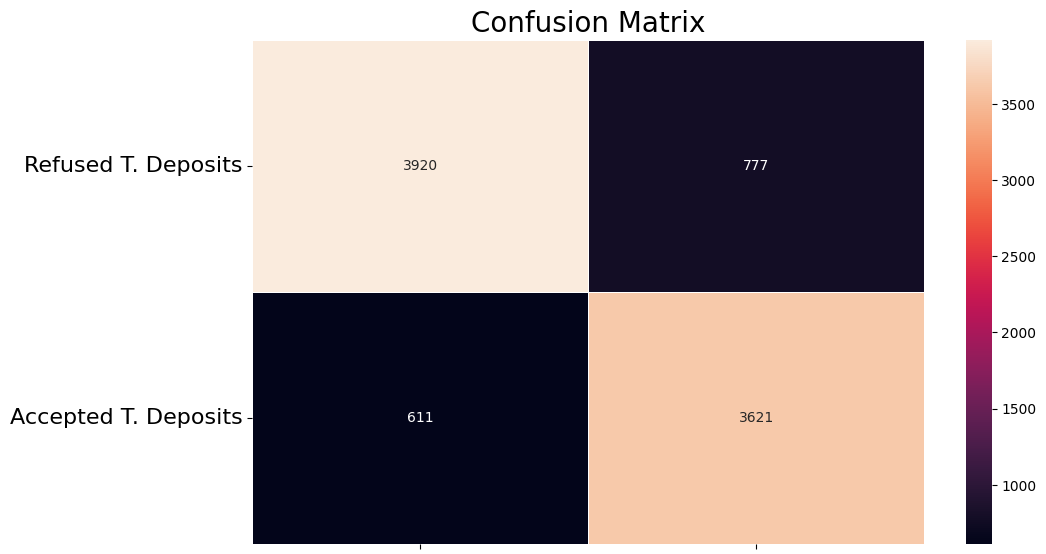

In [18]:
from sklearn.metrics import confusion_matrix
# 4697: no's, 4232: yes
conf_matrix = confusion_matrix(y_train, y_train_pred)
f, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.title("Confusion Matrix", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels("")
ax.set_yticklabels(['Refused T. Deposits', 'Accepted T. Deposits'], fontsize=16, rotation=360)
plt.show()

In [19]:
# Let's find the scores  for precision and recall.
from sklearn.metrics import precision_score, recall_score
# The model is 77% sure that the potential client will suscribe to a term deposit. 
# The model is only retaining 60% of clients that agree to suscribe a term deposit.
print('Precision Score: ', precision_score(y_train, y_train_pred))
# The classifier only detects 60% of potential clients that will suscribe to a term deposit.
print('Recall Score: ', recall_score(y_train, y_train_pred))

Precision Score:  0.8233287858117326
Recall Score:  0.8556238185255198


In [20]:
from sklearn.metrics import f1_score

f1_score(y_train, y_train_pred)

0.8391657010428737

In [21]:
y_scores = cross_val_predict(grad_clf, X_train, y_train, cv=3, method="decision_function")
neural_y_scores = cross_val_predict(neural_clf, X_train, y_train, cv=3, method="predict_proba")
naives_y_scores = cross_val_predict(nav_clf, X_train, y_train, cv=3, method="predict_proba")

In [22]:
# hack to work around issue #9589 introduced in Scikit-Learn 0.19.0
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

if neural_y_scores.ndim == 2:
    neural_y_scores = neural_y_scores[:, 1]
    
if naives_y_scores.ndim == 2:
    naives_y_scores = naives_y_scores[:, 1]

In [23]:
# How can we decide which threshold to use? We want to return the scores instead of predictions with this code.
from sklearn.metrics import precision_recall_curve

precisions, recalls, threshold = precision_recall_curve(y_train, y_scores)

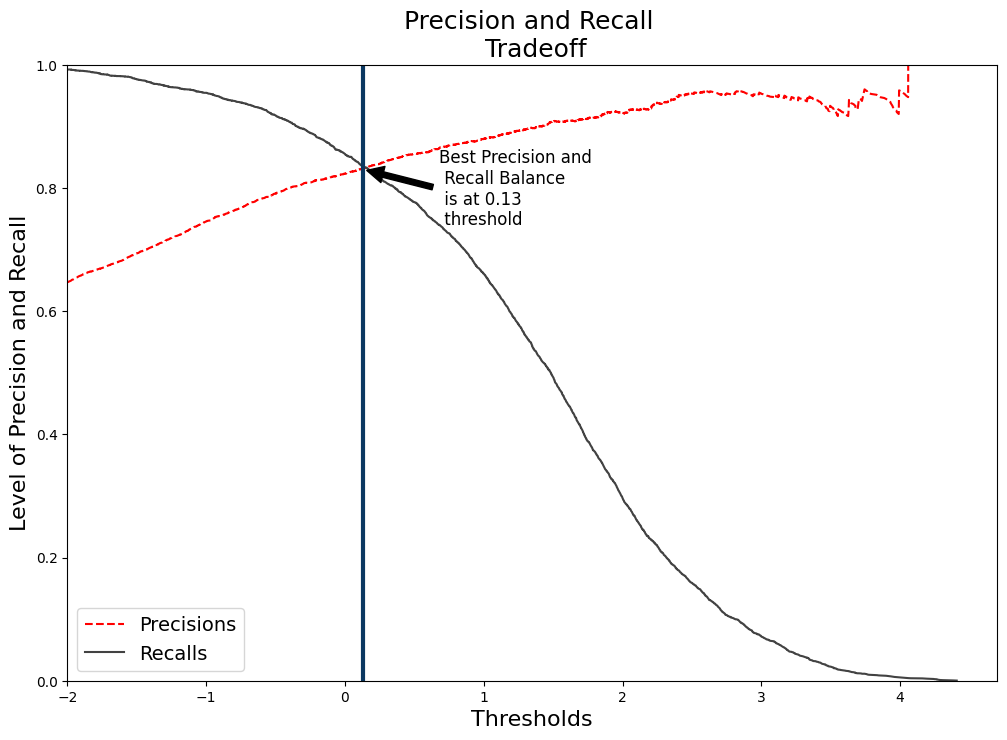

In [24]:
def precision_recall_curve(precisions, recalls, thresholds):
    fig, ax = plt.subplots(figsize=(12,8))
    plt.plot(thresholds, precisions[:-1], "r--", label="Precisions")
    plt.plot(thresholds, recalls[:-1], "#424242", label="Recalls")
    plt.title("Precision and Recall \n Tradeoff", fontsize=18)
    plt.ylabel("Level of Precision and Recall", fontsize=16)
    plt.xlabel("Thresholds", fontsize=16)
    plt.legend(loc="best", fontsize=14)
    plt.xlim([-2, 4.7])
    plt.ylim([0, 1])
    plt.axvline(x=0.13, linewidth=3, color="#0B3861")
    plt.annotate('Best Precision and \n Recall Balance \n is at 0.13 \n threshold ', xy=(0.13, 0.83), xytext=(55, -40),
             textcoords="offset points",
            arrowprops=dict(facecolor='black', shrink=0.05),
                fontsize=12, 
                color='k')
    
precision_recall_curve(precisions, recalls, threshold)
plt.show()

In [25]:
from sklearn.metrics import roc_curve
# Gradient Boosting Classifier
# Neural Classifier
# Naives Bayes Classifier
grd_fpr, grd_tpr, thresold = roc_curve(y_train, y_scores)
neu_fpr, neu_tpr, neu_threshold = roc_curve(y_train, neural_y_scores)
nav_fpr, nav_tpr, nav_threshold = roc_curve(y_train, naives_y_scores)

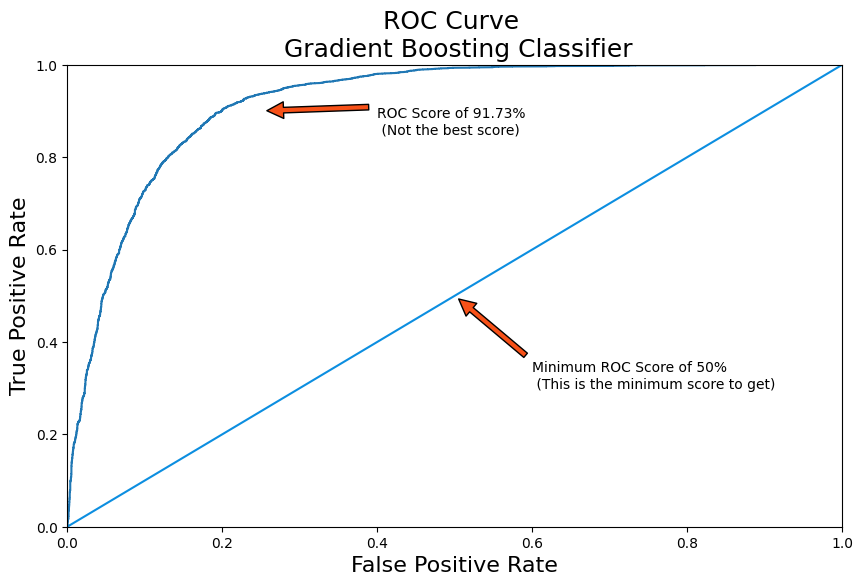

In [26]:
def graph_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.figure(figsize=(10,6))
    plt.title('ROC Curve \n Gradient Boosting Classifier', fontsize=18)
    plt.plot(false_positive_rate, true_positive_rate, label=label)
    plt.plot([0, 1], [0, 1], '#0C8EE0')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('ROC Score of 91.73% \n (Not the best score)', xy=(0.25, 0.9), xytext=(0.4, 0.85),
            arrowprops=dict(facecolor='#F75118', shrink=0.05),
            )
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#F75118', shrink=0.05),
                )
    
    
graph_roc_curve(grd_fpr, grd_tpr, threshold)
plt.show()

In [27]:
from sklearn.metrics import roc_auc_score

print('Gradient Boost Classifier Score: ', roc_auc_score(y_train, y_scores))
print('Neural Classifier Score: ', roc_auc_score(y_train, neural_y_scores))
print('Naives Bayes Classifier: ', roc_auc_score(y_train, naives_y_scores))

Gradient Boost Classifier Score:  0.9173918677931818
Neural Classifier Score:  0.9165369903888295
Naives Bayes Classifier:  0.803352414343226


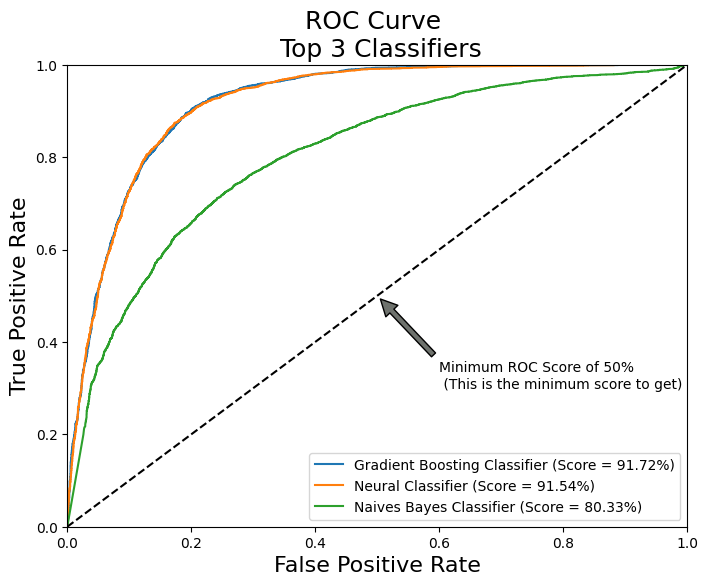

In [28]:
def graph_roc_curve_multiple(grd_fpr, grd_tpr, neu_fpr, neu_tpr, nav_fpr, nav_tpr):
    plt.figure(figsize=(8,6))
    plt.title('ROC Curve \n Top 3 Classifiers', fontsize=18)
    plt.plot(grd_fpr, grd_tpr, label='Gradient Boosting Classifier (Score = 91.72%)')
    plt.plot(neu_fpr, neu_tpr, label='Neural Classifier (Score = 91.54%)')
    plt.plot(nav_fpr, nav_tpr, label='Naives Bayes Classifier (Score = 80.33%)')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(grd_fpr, grd_tpr, neu_fpr, neu_tpr, nav_fpr, nav_tpr)
plt.show()

<ipython-input-29-cd94fcf4b732>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


Feature ranking:
1. feature 11 (0.591310)
2. feature 8 (0.129966)
3. feature 6 (0.067020)
4. feature 13 (0.049923)
5. feature 15 (0.038138)
6. feature 14 (0.037830)
7. feature 10 (0.026646)
8. feature 5 (0.025842)
9. feature 0 (0.017757)
10. feature 12 (0.007889)
11. feature 3 (0.005280)
12. feature 9 (0.002200)
13. feature 2 (0.000147)
14. feature 1 (0.000050)
15. feature 7 (0.000000)
16. feature 4 (0.000000)


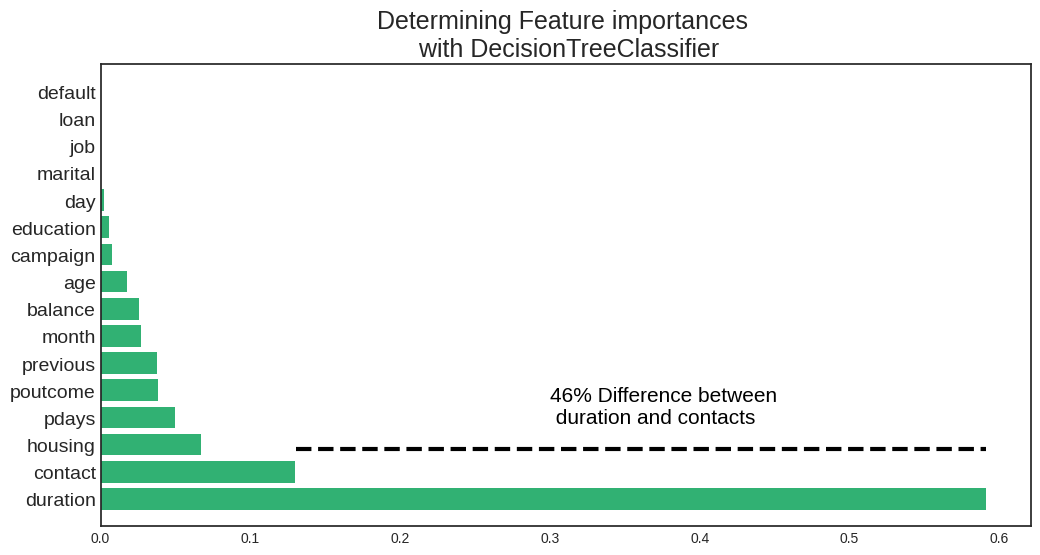

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
plt.style.use('seaborn-white')

# Convert the columns into categorical variables
term_deposits['job'] = term_deposits['job'].astype('category').cat.codes
term_deposits['marital'] = term_deposits['marital'].astype('category').cat.codes
term_deposits['education'] = term_deposits['education'].astype('category').cat.codes
term_deposits['contact'] = term_deposits['contact'].astype('category').cat.codes
term_deposits['poutcome'] = term_deposits['poutcome'].astype('category').cat.codes
term_deposits['month'] = term_deposits['month'].astype('category').cat.codes
term_deposits['default'] = term_deposits['default'].astype('category').cat.codes
term_deposits['loan'] = term_deposits['loan'].astype('category').cat.codes
term_deposits['housing'] = term_deposits['housing'].astype('category').cat.codes

# Let's create new splittings like before but now we modified the data so we need to do it one more time.
# Create train and test splits
target_name = 'deposit'
X = term_deposits.drop('deposit', axis=1)


label=term_deposits[target_name]

X_train, X_test, y_train, y_test = train_test_split(X,label,test_size=0.2, random_state=42, stratify=label)

# Build a classification task using 3 informative features
tree = tree.DecisionTreeClassifier(
    class_weight='balanced',
    min_weight_fraction_leaf = 0.01
    
)



tree = tree.fit(X_train, y_train)
importances = tree.feature_importances_
feature_names = term_deposits.drop('deposit', axis=1).columns
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
def feature_importance_graph(indices, importances, feature_names):
    plt.figure(figsize=(12,6))
    plt.title("Determining Feature importances \n with DecisionTreeClassifier", fontsize=18)
    plt.barh(range(len(indices)), importances[indices], color='#31B173',  align="center")
    plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(indices)])
    plt.axhline(y=1.85, xmin=0.21, xmax=0.952, color='k', linewidth=3, linestyle='--')
    plt.text(0.30, 2.8, '46% Difference between \n duration and contacts', color='k', fontsize=15)
    
feature_importance_graph(indices, importances, feature_names)
plt.show()

In [30]:
# Our three classifiers are grad_clf, nav_clf and neural_clf
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[('gbc', grad_clf), ('nav', nav_clf), ('neural', neural_clf)],
    voting='soft'
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('gbc', GradientBoostingClassifier()),
                             ('nav', GaussianNB()),
                             ('neural', MLPClassifier(alpha=1))],
                 voting='soft')

In [31]:
from sklearn.metrics import accuracy_score

for clf in (grad_clf, nav_clf, neural_clf, voting_clf):
    clf.fit(X_train, y_train)
    predict = clf.predict(X_test)
    print(predict)
    print(clf.__class__.__name__, accuracy_score(y_test, predict))

['yes' 'yes' 'yes' ... 'yes' 'yes' 'yes']
GradientBoostingClassifier 0.8463949843260188
['yes' 'yes' 'yes' ... 'no' 'yes' 'no']
GaussianNB 0.7514554411106136
['yes' 'yes' 'no' ... 'no' 'yes' 'no']
MLPClassifier 0.6484549932825795
['yes' 'yes' 'yes' ... 'yes' 'yes' 'no']
VotingClassifier 0.8114643976712942


Checking Gradient Bosst Classifier results

In [32]:
grad_clf.fit(X_train, y_train)

GradientBoostingClassifier()

In [33]:
predict = grad_clf.predict(X_test)

In [34]:
predict

array(['yes', 'yes', 'yes', ..., 'yes', 'yes', 'yes'], dtype=object)

(array([1117.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1116.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

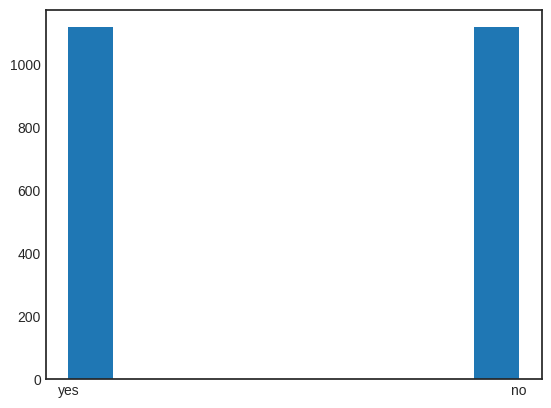

In [35]:
plt.hist(predict)

In [36]:
X_test.to_csv('X_test.csv', index=False)

In [37]:
pd.DataFrame(predict).to_csv('y_pred.csv', index=False)

In [38]:
y_test.to_csv('y_test.csv', index=False)

In [39]:
y_test.to_csv('y_test.csv', index=False)
predict=pd.Series(predict)

In [40]:
accuracy_score(y_test, predict)

0.8463949843260188

In [41]:
y_pred=predict.apply(lambda x:1 if x=='yes' else 0)
y_test=y_test.apply(lambda x:1 if x=='yes' else 0)

In [42]:
# Required installations
!pip install shap==0.39.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.2/356.2 kB 17.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for shap: filename=shap-0.39.0-cp310-cp310-linux_x86_64.whl size=535066 sha256=4f825339b3a5ef0ddab562158953838d5d49aa5e8416230054dfee0e020f5514
  Stored in directory: /root/.cache/pip/wheels/d4/ef/8d/78a07e01b86b1a0363626186f072e01683c10335e2eb89e337
Successfully built shap


In [43]:
# Import the required modules
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import shap
from IPython.display import Image
from IPython.core.display import HTML 
import operator
from collections import defaultdict
shap.initjs()

In [44]:
# Initialize the explainer
explainer = shap.TreeExplainer(grad_clf, X_train, feature_perturbation="interventional")
# Apply it to the test data
shap_values = explainer.shap_values(X_test)

 98%|===================| 2184/2233 [00:23<00:00]       

In [45]:
shap_values.shape

(2233, 16)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


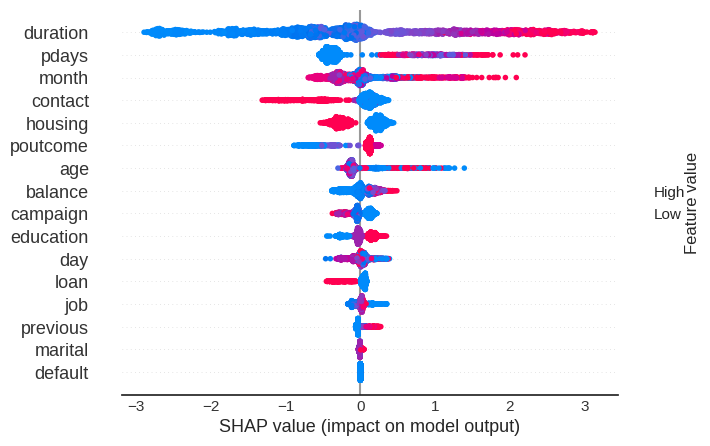

In [46]:
X_test_array = X_test.to_numpy() # We need to provide the data in dense format, not sparse
shap.summary_plot(shap_values, X_test_array, feature_names=X_test.columns, plot_size=(8,5))

In [47]:
X_test_array=X_test.to_numpy()

In [48]:
misclassified[9]

NameError: ignored

In [49]:
p=y_pred.to_numpy()
t=y_test.to_numpy()
misclassified=np.where(p!=t)[0]
#print(misclassified)
sens=np.where(X_test['age']>60)[0]
status=[i for i in sens if i in misclassified]
print(status)
print(X_test.iloc[4])

[100, 152, 239, 364, 450, 492, 578, 581, 721, 921, 989, 1003, 1118, 1142, 1424, 1513, 1825, 2017]
age           41
job            1
marital        1
education      1
default        0
balance     -190
housing        0
loan           1
contact        0
day           29
month          5
duration     808
campaign       3
pdays         -1
previous       0
poutcome       3
Name: 616, dtype: int64


In [50]:
shap.initjs()
import random
idx=random.choice(status)
#idx = 578, 364, 450
idx=450
print(f"Plot for misclassified instance:\n", idx)
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_test_array[idx,:], feature_names=X_test.columns)

Plot for misclassified instance:
 450


In [53]:
shap.initjs()
correct=np.where(p==t)[0]
idx = random.choice(correct)
idx = 1445
print(f"Plot for correctly classified instance:\n", idx)
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_test_array[idx,:], feature_names=X_test.columns)

Plot for correctly classified instance:
 1445


In [52]:
p[1397]==t[1397]

True

In [ ]:
X_test